# Modeling Single Subject Data
*Written by Luke Chang*

*Modified by JD Knotts for Spring 22*

Now that we have learned the basics of the GLM using simulations, it's time to apply this to working with real data. The first step in fMRI data analysis is to build a model for each subject to predict the activation in a single voxel over the entire scanning session. To do this, we need to build a design matrix for our general linear model. We expect distinct brain regions to be involved in processing specific aspects of our task. This means that we will construct separate regressors that model different brain processes. 

In this tutorial, we will learn how to build and estimate a single subject first-level model and will cover the following topics:
- Building a design matrix
- Modeling noise in the GLM with nuisance variables
- Estimating GLM 
- Performing basic contrasts

## Dataset
We will continue to work with the Pinel Localizer dataset from our preprocessing examples.

The Pinel Localizer task was designed to probe several different types of basic cognitive processes, such as visual perception, finger tapping, language, and math. Several of the tasks are cued by reading text on the screen (i.e., visual modality) and also by hearing auditory instructions (i.e., auditory modality). The trials are randomized across conditions and have been optimized to maximize efficiency for a rapid event related design. There are 100 trials in total over a 5-minute scanning session. Read the original [paper](https://bmcneurosci.biomedcentral.com/articles/10.1186/1471-2202-8-91) for more specific details about the task and the [dataset paper](https://doi.org/10.1016/j.neuroimage.2015.09.052). 

This dataset is well suited for these tutorials as it is (a) publicly available to anyone in the world, (b) relatively small (only about 5min), and (c) provides many options to create different types of contrasts.

There are a total of 94 subjects available, but we will primarily only be working with a smaller subset of 10-20 participants. See our tutorial on how to download the data if you are not taking the Psych60 version of the class.

## Building a Design Matrix

First, we will learn the basics of how to build a design matrix for our GLM.

Let's load all of the python modules we will need to complete this tutorial.

In [1]:
%matplotlib inline

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from nltools.file_reader import onsets_to_dm
from nltools.stats import regress, zscore
from nltools.data import Brain_Data, Design_Matrix
from nltools.stats import find_spikes 
from nilearn.plotting import view_img, glass_brain, plot_stat_map
from bids import BIDSLayout, BIDSValidator
from IPython.display import Image

data_dir = '/home/jovyan/shared/PSYCH60-22S/data/localizer'
layout = BIDSLayout(data_dir, derivatives=True)


/opt/conda/lib/python3.9/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.9/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


To build the design matrix, we will be using the Design_Matrix class from the nltools toolbox.  First, we use pandas to load the text file that contains the onset and duration for each condition of the task. Rows reflect measurements in time sampled at 1/tr cycles per second. Columns reflect distinct conditions. Conditions are either on or off. We then cast this Pandas DataFrame as a Design_Matrix object. Be sure to specify the sampling frequency, which is $\frac{1}{tr}$. 

In [2]:
def load_bids_events(layout, subject):
    '''Create a design_matrix instance from BIDS event file'''
    
    tr = layout.get_tr()
    boldFiles = layout.get(subject=subject, scope='derivatives', suffix='bold', return_type='filename', extension='nii.gz')
    preprocFile = [FILE for i,FILE in enumerate(boldFiles) if FILE[-19:] == 'preproc_bold.nii.gz']
    n_tr = nib.load(preprocFile[0]).shape[3]

    onsets = pd.read_csv(layout.get(subject=subject, suffix='events')[0].path, sep='\t')
    onsets.columns = ['Onset', 'Duration', 'Stim']
    return onsets_to_dm(onsets, sampling_freq=1/tr, run_length=n_tr), preprocFile

dm,preprocFile = load_bids_events(layout, 'S01')

/opt/conda/lib/python3.9/site-packages/nltools/file_reader.py:140: UserWarning: Computed onsets for video_right_hand are inconsistent with expected values. Please manually verify the outputted Design_Matrix!
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/nltools/file_reader.py:140: UserWarning: Computed onsets for video_left_hand are inconsistent with expected values. Please manually verify the outputted Design_Matrix!
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/nltools/file_reader.py:140: UserWarning: Computed onsets for audio_computation are inconsistent with expected values. Please manually verify the outputted Design_Matrix!
  warnings.warn(


In [3]:
subject = 'S01'
tr = layout.get_tr()
boldFiles = layout.get(subject=subject, scope='derivatives', suffix='bold', return_type='filename', extension='nii.gz')
[FILE for i,FILE in enumerate(boldFiles) if FILE[-19:] == 'preproc_bold.nii.gz']
n_tr = nib.load(preprocFile[0]).shape[3]
onsets = pd.read_csv(layout.get(subject=subject, suffix='events')[0].path, sep='\t')
onsets.columns = ['Onset', 'Duration', 'Stim']
onsets

,Onset,Duration,Stim
0,0.0,1,video_computation
1,2.4,1,video_computation
2,8.7,1,horizontal_checkerboard
3,11.4,1,audio_right_hand
4,15.0,1,audio_sentence
...,...,...,...
75,284.4,1,audio_sentence
76,288.0,1,video_sentence
77,291.0,1,video_right_hand
78,293.4,1,audio_sentence


In [4]:
dm

,video_computation,horizontal_checkerboard,audio_right_hand,audio_sentence,video_right_hand,audio_left_hand,video_left_hand,vertical_checkerboard,audio_computation,video_sentence
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
123,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
124,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
126,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The Design_Matrix class is built on top of Pandas DataFrames and retains most of that functionality. There are additional methods to help with building design matrices. Be sure to check out this [tutorial](https://neurolearn.readthedocs.io/en/latest/auto_examples/01_DataOperations/plot_design_matrix.html#sphx-glr-auto-examples-01-dataoperations-plot-design-matrix-py) for more information about how to use this tool. 

We can check out details about the data using the `.info()` method.

In [5]:
dm.info()

<class 'nltools.data.design_matrix.Design_Matrix'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   video_computation        128 non-null    float64
 1   horizontal_checkerboard  128 non-null    float64
 2   audio_right_hand         128 non-null    float64
 3   audio_sentence           128 non-null    float64
 4   video_right_hand         128 non-null    float64
 5   audio_left_hand          128 non-null    float64
 6   video_left_hand          128 non-null    float64
 7   vertical_checkerboard    128 non-null    float64
 8   audio_computation        128 non-null    float64
 9   video_sentence           128 non-null    float64
dtypes: float64(10)
memory usage: 10.1 KB


We can also view the raw design matrix as a dataframe just like pd.Dataframe.  We use the `.head()` method to just post the first few rows.

In [6]:
dm.head()

,video_computation,horizontal_checkerboard,audio_right_hand,audio_sentence,video_right_hand,audio_left_hand,video_left_hand,vertical_checkerboard,audio_computation,video_sentence
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We can plot each regressor's time course using the `.plot()` method.

<AxesSubplot:>

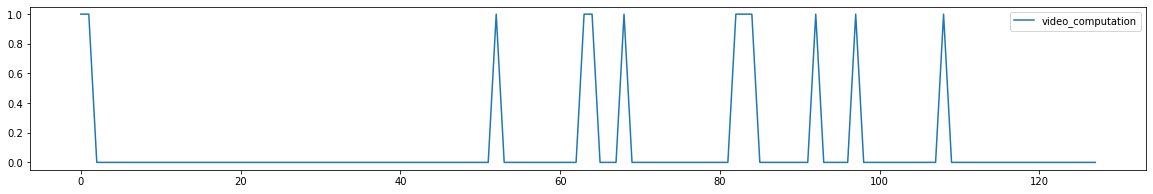

In [7]:
f,a = plt.subplots(figsize=(20,3))
dm.iloc[:,:1].plot(ax=a)

This plot can be useful sometimes, but here there are too many regressors, which makes it difficult to see what is going on.

Often,  `.heatmap()` method provides a more useful visual representation of the design matrix.

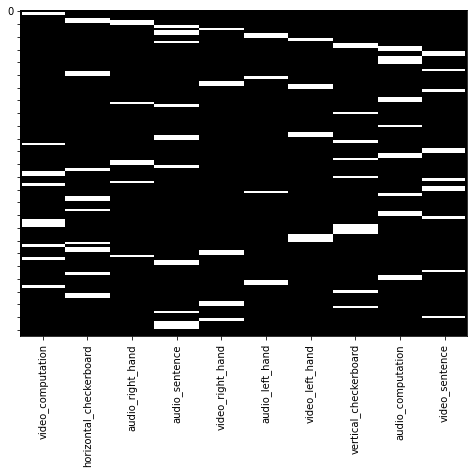

In [8]:
dm.heatmap()

### HRF Convolution
Recall what we learned about convolution in our signal processing tutorial. We can now convolve all of the onset regressors with an HRF function using the `.convolve()` method. By default it will convolve all regressors with the standard double gamma HRF function, though you can specify custom ones and also specific regressors to convolve. Check out the docstrings for more information by adding a `?` after the function name. If you are interested in learning more about different ways to model the HRF using temporal basis functions, watch this [video](https://www.youtube.com/watch?v=YfeMIcDWwko&t=9s).

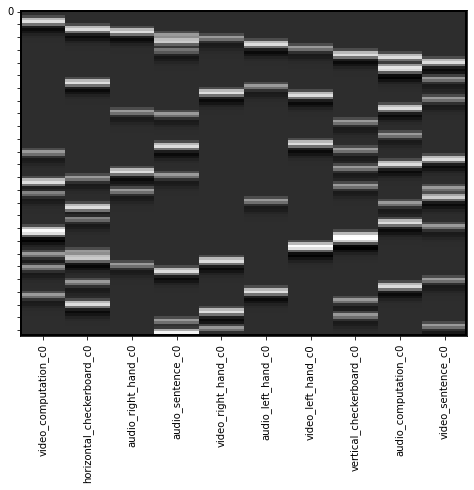

In [9]:
dm_conv = dm.convolve()
dm_conv.heatmap()

You can see that each of the regressors is now  bit blurrier and now has the shape of an HRF function. We can plot a single regoressor to see this more clearly using the `.plot()` method.

<AxesSubplot:>

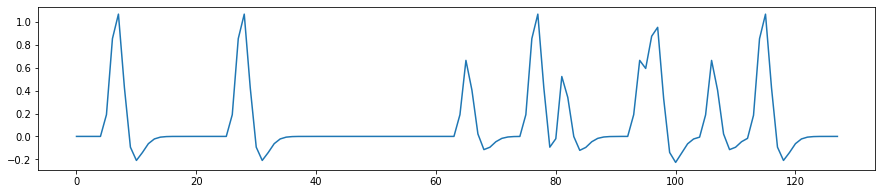

In [10]:
f,a = plt.subplots(figsize=(15,3))
dm_conv['horizontal_checkerboard_c0'].plot(ax=a)

Maybe we want to plot both of the checkerboard regressors.

<AxesSubplot:>

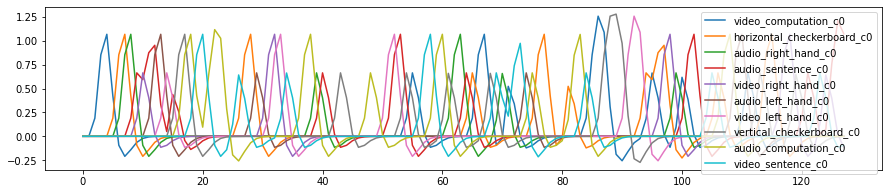

In [11]:
f,a = plt.subplots(nrows=1, figsize=(15,3))
dm_conv.plot(ax=a)

### Multicollinearity
In statistics, collinearity or multicollinearity is when one regressor can be strongly linearly predicted from the others. While this does not actually impact the model's ability to predict data as a whole, it will impact our ability to accurately attribute variance to a single regressor. Recall that in multiple regression, we are estimating the independent variance from each regressor from `X` on `Y`. If there is substantial overlap between the regressors, then the estimator can not attribute the correct amount of variance each regressor accounts for `Y` and the coefficients can become unstable. A more intuitive depiction of this problem can be seen in the venn diagram. The dark orange area in the center at the confluence of all 3 circles reflects the shared variance between `X1` and `X2` on `Y`. If this area becomes bigger, the unique variances become smaller and individually reflect less of the total variance on `Y`.

![MultipleRegression.png](https://dartbrains.org/_images/MultipleRegression.png)

One way to evaluate multicollinearity is to examine the pairwise correlations between each regressor. We plot the correlation matrix as a heatmap.

<AxesSubplot:>

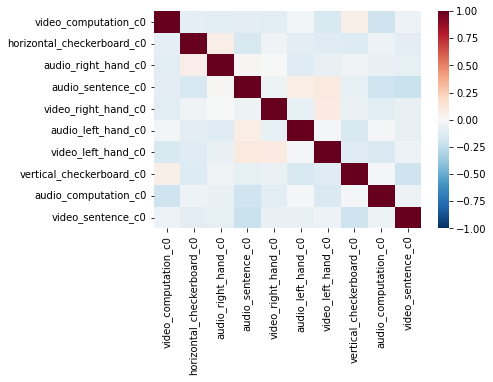

In [12]:
sns.heatmap(dm_conv.corr(), vmin=-1, vmax=1, cmap='RdBu_r')

#### Variance Inflation Factor
Pairwise correlations will let you know if any regressor is correlated with another regressor. However, we are even more concerned about being able to explain any regressor as a linear combination of the other regressors. For example, *can one regressor be explained by three or more of the remaining regressors?* The variance inflation factor (VIF) is a metric that can help us detect multicollinearity. Specifically, it is simply the ratio of variance in a model with multiple terms, divided by the variance of a model with only a single term. This ratio reduces to the following formula:

$$VIF_j=\frac{1}{1-R_i^2}$$

Where $R_j^2$ is the $R^2$ value obtained by regressing the $jth$ predictor on the remaining predictors. This means that each regressor $j$ will have it's own variance inflation factor.

How should we interpret the VIF values?  

A VIF of 1 indicates that there is no correlation among the $jth$ predictor and the remaining variables. Values greater than 4 should be investigated further, while VIFs exceeding 10 indicate significant multicollinearity and will likely require intervention.

Here we will use the `.vif()` method to calculate the variance inflation factor for our design matrix.

See this [overview](https://newonlinecourses.science.psu.edu/stat501/node/347/) for more details on VIFs.

Text(0, 0.5, 'Variance Inflation Factor')

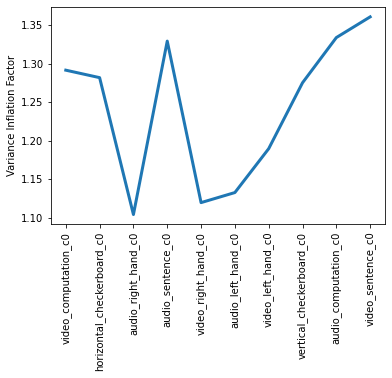

In [13]:
plt.plot(dm_conv.columns, dm_conv.vif(), linewidth=3)
plt.xticks(rotation=90)
plt.ylabel('Variance Inflation Factor')

#### Orthogonalization
There are many ways to deal with collinearity. In practice, don't worry about collinearity between your covariates. The more pernicious issues are collinearity in your experimental design. 

It is commonly thought that using a procedure called orthogonalization should be used to address issues of multicollinearity. In linear algebra, orthogonalization is the process of prioritizing shared variance between regressors to a single regressor. Recall that the standard GLM already accounts for shared variance by removing it from individual regressors. Orthogonalization allows a user to assign that variance to a specific regressor. However, the process of performing this procedure can introduce artifact into the model and often changes the interpretation of the beta weights in unanticipated ways.

![Orthogonalization.png](https://dartbrains.org/_images/Orthogonalization.png)

In general, we do not recommend using orthogonalization in most use cases, with the exception of centering regressor variables. We encourage the interested reader to review this very useful [overview](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0126255) of collinearity and orthogonalization by Jeanette Mumford and colleagues.

## Nuisance Variables

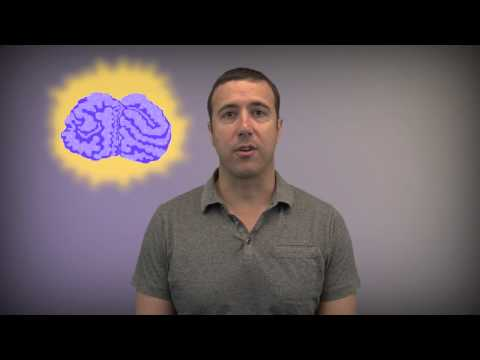

In [14]:
from IPython.display import YouTubeVideo

YouTubeVideo('DEtwsFdFwYc')

### Filtering
Recall from our signal processing tutorial, that there are often other types of artifacts in our signal that might take the form of slow or fast oscillations. It is common to apply a high pass filter to the data to remove low frequency artifacts. Often this can also be addressed by simply using a few polynomials to model these types of trends. If we were to directly filter the brain data using something like a butterworth filter as we did in our signal processing tutorial, we would also need to apply it to our design matrix to make sure that we don't have any low frequency drift in experimental design. One easy way to simultaneously perform both of these procedures is to simply build a filter into the design matrix. We will be using a discrete cosine transform (DCT), which is a basis set of cosine regressors of varying frequencies up to a filter cutoff of a specified number of seconds. Many software use 100s or 128s as a default cutoff, but we encourage caution that the filter cutoff isn't too short for your specific experimental design. Longer trials will require longer filter cutoffs. See this [paper](https://www.sciencedirect.com/science/article/pii/S1053811900906098) for a more technical treatment of using the DCT as a high pass filter in fMRI data analysis. In addition, here is a more detailed discussion about [filtering](http://mindhive.mit.edu/node/116).

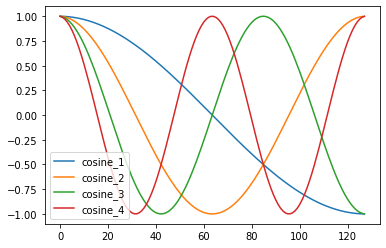

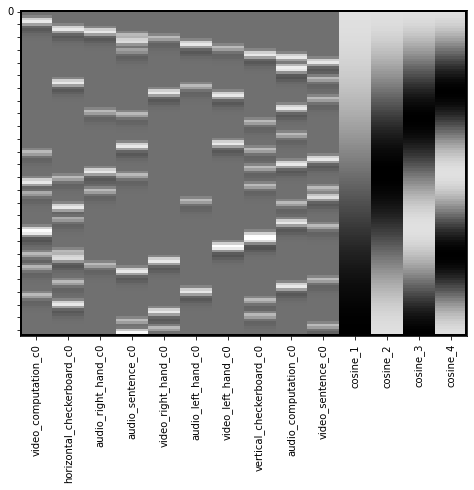

In [15]:
dm_conv_filt = dm_conv.add_dct_basis(duration=128)
dm_conv_filt.iloc[:,10:].plot()
dm_conv_filt.heatmap()

### Intercepts
We almost always want to include an intercept in our model. This will usually reflect the baseline, or the average voxel response during the times that are not being modeled as a regressor. It is important to note that you must have some sparsity to your model, meaning that you can't model every point in time, as this will make your model rank deficient and unestimable.

If you are concatenating runs and modeling them all together, it is recommended to include a separate intercept for each run, but not for the entire model. This means that the average response within a voxel might differ across runs. You can add an intercept by simply creating a new column of ones (e.g., `dm['Intercept] = 1`). Here we provide an example using the `.add_poly()` method, which adds an intercept by default.

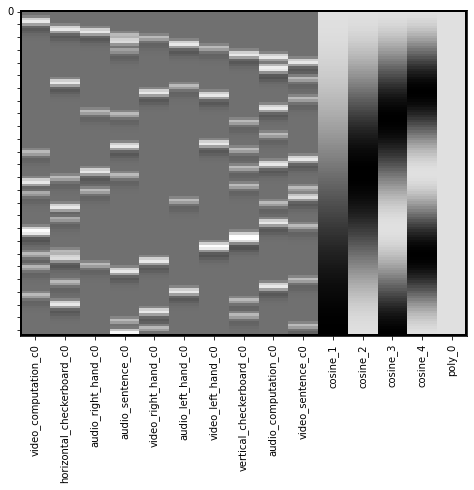

In [16]:
dm_conv_filt_poly = dm_conv_filt.add_poly()
dm_conv_filt_poly.heatmap()

### Linear Trends
We also often want to remove any slow drifts in our data.  This might include a linear trend and a quadratic trend. We can also do this with the `.add_poly()` method and adding all trends up to an order of 2 (e.g., quadratic). We typically use this approach rather than applying a high pass filter when working with naturalistic viewing data.

Notice that these do not appear to be very different from the high pass filter basis set. It's actually okay if there is collinearity in our covariate regressors. Collinearity is only a problem when it correlates with the task regressors as it means that we will not be able to uniquely model the variance. The DCT can occasionally run into edge artifacts, which can be addressed by the linear trend.

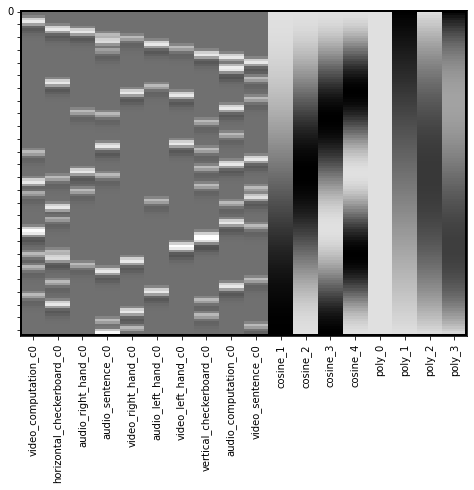

In [17]:
dm_conv_filt_poly = dm_conv_filt.add_poly(order=3, include_lower=True)
dm_conv_filt_poly.heatmap()

### Noise Covariates
Another important thing to consider is removing variance associated with head motion. Remember the preprocessed data has already realigned each TR in space, but head motion itself can nonlinearly distort the magnetic field. There are several common strategies for trying to remove artifacts associated with head motion. One is using a data driven denoising algorithm like ICA and combining it with a classifer such as FSL's [FIX](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/FIX) module. Another approach is to include the amount of correction that needed to be applied to align each TR. For example, if someone moved a lot in a single TR, there will be a strong change in their realignment parameters. It is common to include the 6 parameters as covariates in your regression model. However, as we already noted, often motion can have a nonlinear relationship with signal intensity, so it is often good to include other transformations of these signals to capture nonlinear signal changes resulting from head motion. We typically center the six realigment parameters (or zscore) and then additionally add a quadratic version, a derivative, and the square of the derivatives, which becomes 24 additional regressors. 

In addition, it is common to model out big changes using a regressor with a single value indicating the timepoint of the movement. This will be zeros along time, with a single value of one at the time point of interest. This effectively removes any variance associated with this single time point. It is important to model each "spike" as a separate regressor as there might be distinct spatial patterns associated with different types of head motions. We strongly recommond against using a single continuous frame displacement metric as is often recommended by the fMRIprep team. This assumes (1) that there is a *linear* relationship between displacement and voxel activity, and (2) that there is a *single* spatial generator or pattern associated with frame displacement. As we saw in the ICA noise lab, there might be many different types of head motion artifacts. This procedure of including spikes as nuisance regressors is mathematically equivalent to censoring your data and removing the bad TRs. We think it is important to do this in the context of the GLM as it will also reduce the impact if it happens to covary with your task.

First, let's load preprocessed data from one participant.

In [18]:
data = Brain_Data(preprocFile)

Now let's inspect the realignment parameters for this participant. These pertain to how much each volume had to be moved in the (X,Y,Z) planes and rotations around each axis. We are standardizing the data so that rotations and translations are on the same scale.

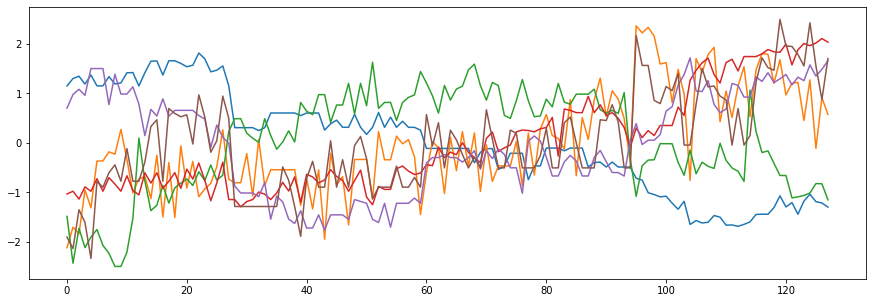

In [19]:
covariates = pd.read_csv(layout.get(subject='S01', scope='derivatives', extension='.tsv')[0].path, sep='\t')

mc = covariates[['trans_x','trans_y','trans_z','rot_x', 'rot_y', 'rot_z']]

plt.figure(figsize=(15,5))
plt.plot(zscore(mc))

In [20]:
mc

,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
0,-0.028014,-0.038885,-0.033840,-0.000634,0.000344,-0.000701
1,-0.019273,-0.019809,-0.076608,-0.000541,0.000569,-0.000776
2,-0.016559,-0.026117,-0.044713,-0.000805,0.000655,-0.000524
3,-0.025758,0.014727,-0.062380,-0.000396,0.000554,-0.000605
4,-0.015119,-0.001858,-0.052669,-0.000541,0.000997,-0.000840
...,...,...,...,...,...,...
123,-0.163355,0.079298,-0.014695,0.004400,0.000796,0.000413
124,-0.155273,0.116979,-0.012484,0.004331,0.001057,0.000694
125,-0.164000,0.053374,-0.003813,0.004420,0.000872,0.000413
126,-0.165545,0.100347,-0.004032,0.004567,0.000984,0.000194


Now, let's build the 24 covariates related to head motion. We include the 6 realignment parameters that have been standardized. In addition, we add their quadratic, their derivative, and the square of their derivative.

We can create a quick visualization to see what the overall pattern is across the different regressors.

<AxesSubplot:>

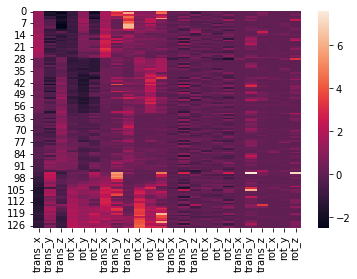

In [21]:
def make_motion_covariates(mc, tr):
    z_mc = zscore(mc)
    all_mc = pd.concat([z_mc, z_mc**2, z_mc.diff(), z_mc.diff()**2], axis=1)
    all_mc.fillna(value=0, inplace=True)
    return Design_Matrix(all_mc, sampling_freq=1/tr)

tr = layout.get_tr()
mc_cov = make_motion_covariates(mc, tr)

sns.heatmap(mc_cov)

Now let's try to find some spikes in the data. This is performed by finding TRs that exceed a global mean threshold and also that exceed an overall average intensity change by a threshold.  We are using an arbitrary cutoff of 3 standard deviations as a threshold.

First, let's plot the average signal intensity across all voxels over time.

Text(0, 0.5, 'Intensity')

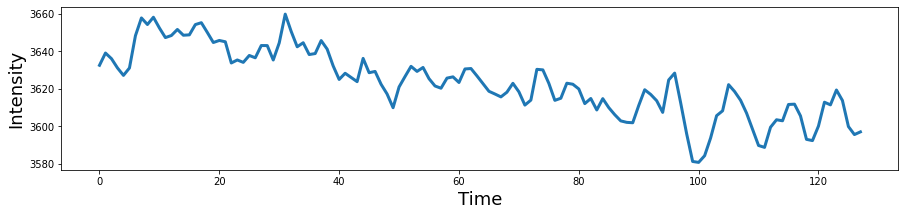

In [22]:
plt.figure(figsize=(15,3))
plt.plot(np.mean(data.data, axis=1), linewidth=3)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Intensity', fontsize=18)

Notice there is a clear slow drift in the signal that we will need to remove with our high pass filter.

Now, let's see if there are any spikes in the data that exceed our threshold. What happens if we use a different threshold?

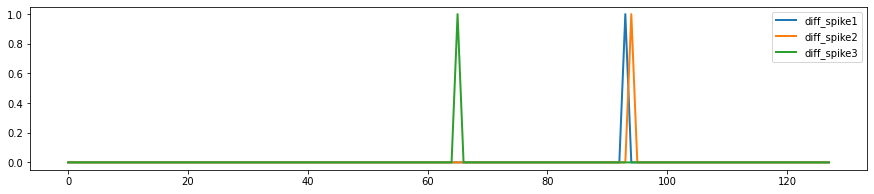

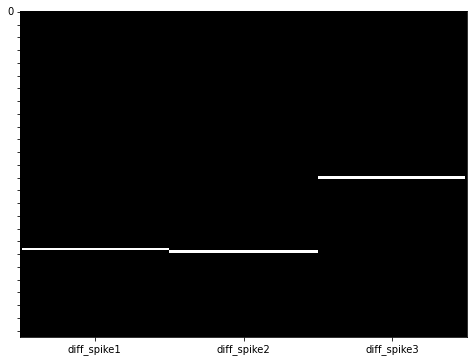

In [23]:
spikes = data.find_spikes(global_spike_cutoff=2.5, diff_spike_cutoff=2.5)

f, a = plt.subplots(figsize=(15,3))
spikes = Design_Matrix(spikes.iloc[:,1:], sampling_freq=1/tr)
spikes.plot(ax = a, linewidth=2)
spikes.heatmap()

For this subject, our spike identification procedure only found a single spike. Let's add all of these covariate to our design matrix.

In this example, we will append each of these additional matrices to our main design matrix. 

**Note**: `.append()` requires that all matrices are a design_matrix with the same sampling frequency.

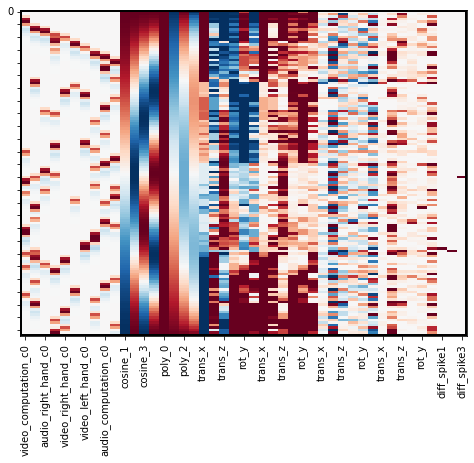

In [24]:
dm_conv_filt_poly_cov = pd.concat([dm_conv_filt_poly, mc_cov, spikes], axis=1)
dm_conv_filt_poly_cov.heatmap(cmap='RdBu_r', vmin=-1,vmax=1)

## Smoothing

To increase the signal to noise ratio and clean up the data, it is common to apply spatial smoothing to the image.

Here we will convolve the image with a 3-D gaussian kernel, with a 6mm full width half maximum (FWHM) using the `.smooth()` method. 

In [25]:
fwhm=6
smoothed = data.smooth(fwhm=fwhm)

Let's take a look and see how this changes the image.

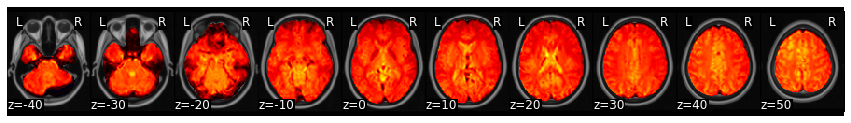

In [26]:
data.mean().plot()

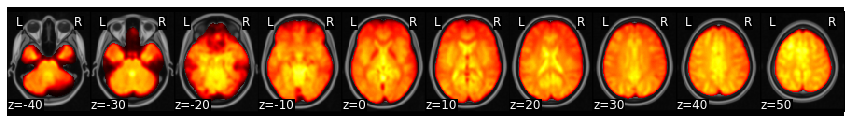

In [27]:
smoothed.mean().plot()

## Estimate GLM for all voxels
Now we are ready to estimate the regression model for all voxels.

We will assign the design_matrix object to the `.X` attribute of our `Brain_Data` instance.

Then we simply need to run the `.regress()` method.

In [28]:
smoothed.X = dm_conv_filt_poly_cov
stats = smoothed.regress()

print(stats.keys())

dict_keys(['beta', 't', 'p', 'sigma', 'residual'])


In [29]:
stats['beta'].data.shape

(45, 238955)

Ok, it's done! Let's take a look at the results.

The stats variable is a dictionary with the main results from the regression: a brain image with all of the betas for each voxel, a correspondign image of t-values, p-values, standard error of the estimate, and residuals.

Remember we have run the same regression model separately on each voxel of the brain.

Let's take a look at one of the regressors. The names of each of them are in the column names of the design matrix, which is in the `data.X` field.  We can print them to see the names. Let's plot the first one, which is a horizontal checkerboard.

In [30]:
print(smoothed.X.columns)

Index(['video_computation_c0', 'horizontal_checkerboard_c0',
       'audio_right_hand_c0', 'audio_sentence_c0', 'video_right_hand_c0',
       'audio_left_hand_c0', 'video_left_hand_c0', 'vertical_checkerboard_c0',
       'audio_computation_c0', 'video_sentence_c0', 'cosine_1', 'cosine_2',
       'cosine_3', 'cosine_4', 'poly_0', 'poly_1', 'poly_2', 'poly_3',
       'trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'trans_x',
       'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'trans_x', 'trans_y',
       'trans_z', 'rot_x', 'rot_y', 'rot_z', 'trans_x', 'trans_y', 'trans_z',
       'rot_x', 'rot_y', 'rot_z', 'diff_spike1', 'diff_spike2', 'diff_spike3'],
      dtype='object')


Brain_Data instances have their own plotting methods. We will be using `.iplot()` here, which can allow us to interactively look at all of the values.

If you would like to see the top values, we can quickly apply a threshold. Try using `95`% threshold, and be sure to click the `percentile_threshold` option.

In [31]:
stats['beta'][1].iplot()

interactive(children=(FloatText(value=0.0, description='Threshold'), HTML(value='Image is 3D', description='Vo…

### Save Image
We will frequently want to save different brain images we are working with to a nifti file. This is useful for saving intermediate work, or sharing our results with others. This is easy with the `.write()` method. Be sure to specify a path and file name for the file.

**Note**: You can only write to folders where you have permission. Try changing the path to your own directory.

In [32]:
sub='S01'
smoothed[:10].write('inClassExample.nii.gz')

## Contrasts

Now that we have estimated our model, we will likely want to create contrasts to examine brain activation to different conditions.

This procedure is identical to those introduced in our GLM tutorial.

Let's watch another video by Tor Wager to better understand contrasts at the first-level model stage.

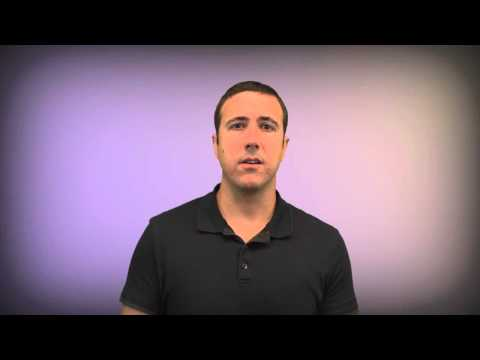

In [33]:
YouTubeVideo('7MibM1ATai4')

Now, let's try making a simple contrast where we average only the regressors pertaining to motor tasks.

First let's look at the shape of the array containing our beta estimates. It has the shape [betas x voxels].

In [34]:
stats['beta'].data.shape

(45, 238955)

To make our contrast we will use matrix multiplication to sum across the 4 rows corresponding to the motor task regressors.

Note that if we want the *mean* beta value across motor task regressors, we have to divide each individual beta by the total number of motor task regressors before summing.

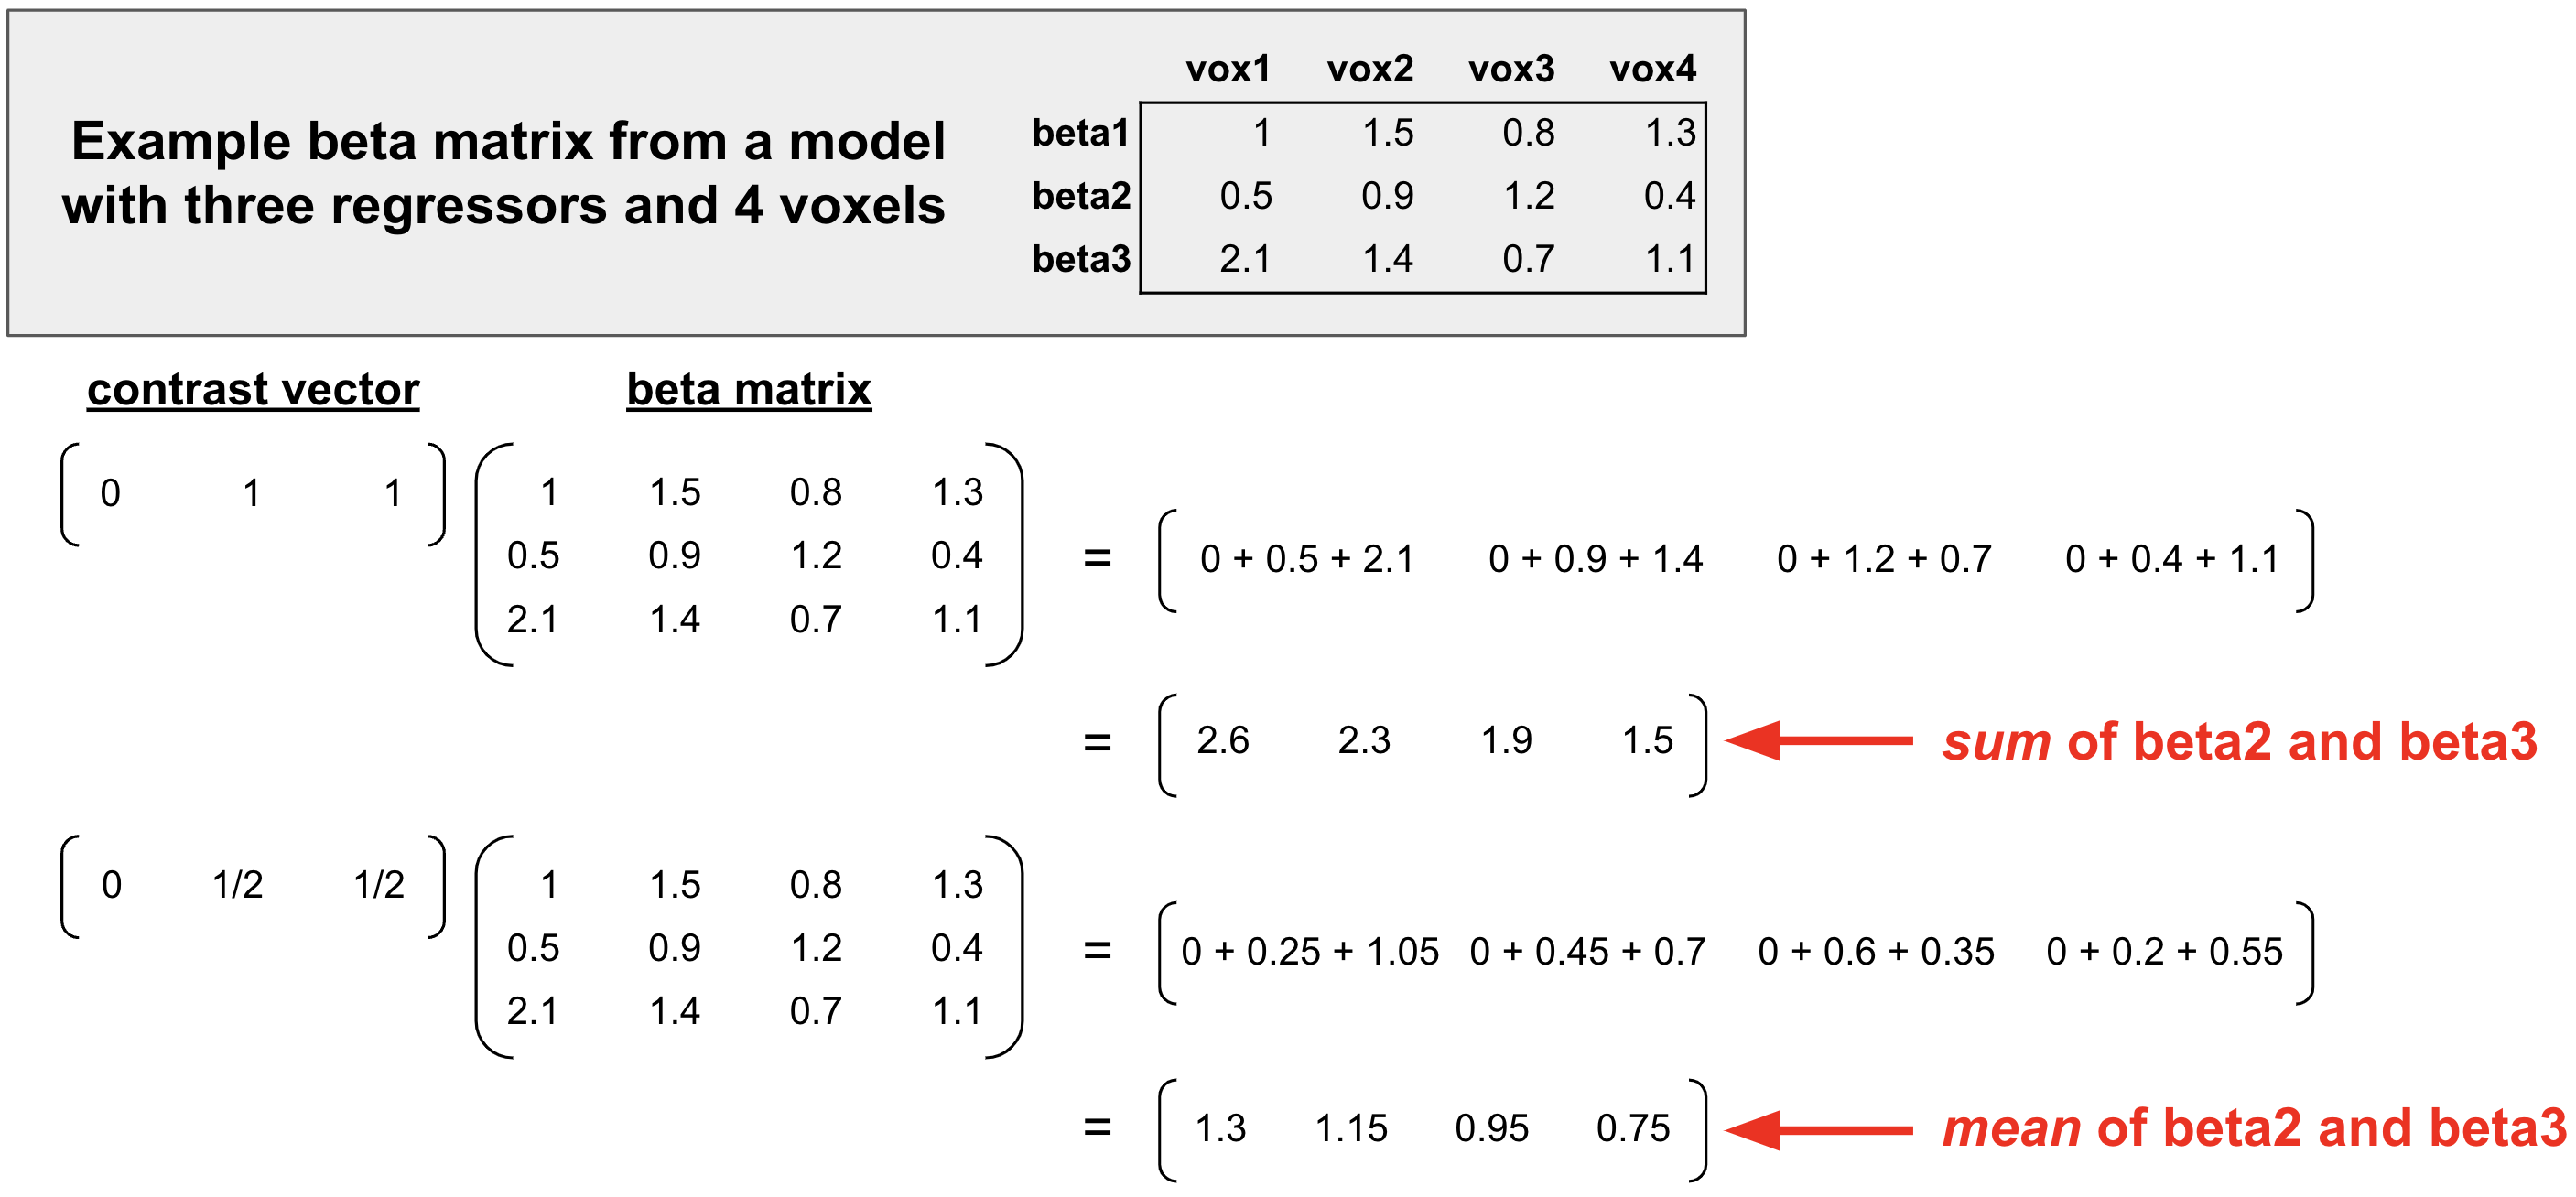

In [35]:
Image("/home/jovyan/shared/PSYCH60-22S/images/single_subject/example_contrast_matrix_mutiplication.png")

Note also that, while the syntax may look backwards, "stats['beta'] * c1", where stats['beta'] is the beta matrix as a Brain_Data object and c1 is the contrast vector, performs the matrix multiplication outlined in the image above.

In [36]:
# print design matrix column labels
print(smoothed.X.columns)

# get column indices of regressors of interest (here, motor tasks)
conInds = [2,4,5,6] 

# make contrast vector
c1 = np.zeros(len(stats['beta'])) # initialize a vector of zeros with length = # regressors in model
c1[conInds] = 1/len(conInds) # for each regressor of interest, set the corresponding index in c1 to one over the total number of regressors of interest 
print(c1) # print contrast vector

# get the mean beta value across motor tasks
motor = stats['beta'] * c1

# plot mean beta estimates across the 4 motor tasks
motor.iplot()

Index(['video_computation_c0', 'horizontal_checkerboard_c0',
       'audio_right_hand_c0', 'audio_sentence_c0', 'video_right_hand_c0',
       'audio_left_hand_c0', 'video_left_hand_c0', 'vertical_checkerboard_c0',
       'audio_computation_c0', 'video_sentence_c0', 'cosine_1', 'cosine_2',
       'cosine_3', 'cosine_4', 'poly_0', 'poly_1', 'poly_2', 'poly_3',
       'trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'trans_x',
       'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'trans_x', 'trans_y',
       'trans_z', 'rot_x', 'rot_y', 'rot_z', 'trans_x', 'trans_y', 'trans_z',
       'rot_x', 'rot_y', 'rot_z', 'diff_spike1', 'diff_spike2', 'diff_spike3'],
      dtype='object')
[0.   0.   0.25 0.   0.25 0.25 0.25 0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.  ]


interactive(children=(FloatText(value=0.0, description='Threshold'), HTML(value='Image is 3D', description='Vo…

In [37]:
c1

array([0.  , 0.  , 0.25, 0.  , 0.25, 0.25, 0.25, 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  ])

In [38]:
dm.info()

<class 'nltools.data.design_matrix.Design_Matrix'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   video_computation        128 non-null    float64
 1   horizontal_checkerboard  128 non-null    float64
 2   audio_right_hand         128 non-null    float64
 3   audio_sentence           128 non-null    float64
 4   video_right_hand         128 non-null    float64
 5   audio_left_hand          128 non-null    float64
 6   video_left_hand          128 non-null    float64
 7   vertical_checkerboard    128 non-null    float64
 8   audio_computation        128 non-null    float64
 9   video_sentence           128 non-null    float64
dtypes: float64(10)
memory usage: 10.1 KB


Ok, now we can clearly see regions specifically involved in motor processing.

Now let's see which regions are more active when making motor movements with our right hand compared to our left hand.

In [39]:
c_rvl = np.zeros(len(stats['beta']))
c_rvl[[2,4,5,6]] = [.5, .5, -.5, -.5]

motor_rvl = stats['beta'] * c_rvl

motor_rvl.iplot()

interactive(children=(FloatText(value=0.0, description='Threshold'), HTML(value='Image is 3D', description='Vo…

What do you see?

## Exercises

For homework, let's get a better handle on how to play with our data and test different hypotheses.

### 1. Which regions are more involved with visual compared to auditory sensory processing?
 - Create a contrast to test this hypothesis
 - plot the results
 - write the file to your output folder.

In [40]:
# get indices of betas to contrast (run dm.info() to get an easy-to-parse list)
vInds = [0, 1, 4, 6, 7, 9] # video indices
aInds = [2, 3, 5, 8] # audio indices

# initialize contrast vector
c1 = np.zeros(len(stats['beta']))
c1[vInds] = 1/len(vInds)
c1[aInds] = -1/len(aInds)
c1

vva = stats['beta'] * c1

vva.iplot()

vva.write('exercise_1_vva.nii.gz')


interactive(children=(FloatText(value=0.0, description='Threshold'), HTML(value='Image is 3D', description='Vo…

In [41]:
dm.info()

<class 'nltools.data.design_matrix.Design_Matrix'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   video_computation        128 non-null    float64
 1   horizontal_checkerboard  128 non-null    float64
 2   audio_right_hand         128 non-null    float64
 3   audio_sentence           128 non-null    float64
 4   video_right_hand         128 non-null    float64
 5   audio_left_hand          128 non-null    float64
 6   video_left_hand          128 non-null    float64
 7   vertical_checkerboard    128 non-null    float64
 8   audio_computation        128 non-null    float64
 9   video_sentence           128 non-null    float64
dtypes: float64(10)
memory usage: 10.1 KB


### 2. Which regions are more involved in processing numbers compared to words?
 - Create a contrast to test this hypothesis
 - plot the results
 - write the file to your output folder.

In [42]:
cInds = [0, 8]
wInds = [3, 9]

# initialize contrast vector
c1 = np.zeros(len(stats['beta']))
c1[cInds] = 1/len(cInds)
c1[wInds] = -1/len(wInds)
c1

cvw = stats['beta'] * c1

cvw.iplot()

cvw.write('exercise_2_cvw.nii.gz')


interactive(children=(FloatText(value=0.0, description='Threshold'), HTML(value='Image is 3D', description='Vo…

### 3. Which regions are more involved with motor compared to cognitive processes (e.g., language and math)?
 - Create a contrast to test this hypothesis
 - plot the results
 - write the file to your output folder.

In [ ]:
mInds = [2,4,5,6]
cInds = [0,3,8,9]

# initialize contrast vector
c1 = np.zeros(len(stats['beta']))
c1[mInds] = 1/len(mInds)
c1[cInds] = -1/len(cInds)
c1

mvc = stats['beta'] * c1

mvc.iplot()

mvc.write('exercise_3_mvc.nii.gz')

interactive(children=(FloatText(value=0.0, description='Threshold'), HTML(value='Image is 3D', description='Vo…

### 4. How are your results impacted by different smoothing kernels?
 - Pick two different sized smoothing kernels and create two new brain images with each smoothing kernel
 - Pick any contrast of interest to you and evaluate the impact of smoothing on the contrast.
 - plot the results
 - write the file to your output folder.

In [ ]:
fwhm=[2, 10]

# initialize contrast vector
c1 = np.zeros(len(stats['beta']))

c1[1] = 1 # horizontal
c1[7] = -1 # vert

for FWHM in fwhm:
    
    # smooth
    smoothed = data.smooth(fwhm=FWHM)
    
    # add design matrix and regress
    smoothed.X = dm_conv_filt_poly_cov
    stats = smoothed.regress()
    
    # apply contrast
    hvv = stats['beta'] * c1
    
    # plot
    hvv.iplot()
    
    # write
    hvv.write(f'exercise_4_hvv_fwhm{FWHM}.nii.gz')


